# Assignment 6
Collaborative work by Adrian Bremer & Philipp Reinig

# Setup

### Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
tfkl = tf.keras.layers

### Hyperparameters

In [2]:
# Optimizing the Model

num_words = 5000

batch_size = 128
epochs = 10
learning_rate = 0.001

hidden_size = 128
use_softmax = False

shall_print_training_info = True

### Utils

In [3]:
def print_training_info(epoch, training_loss, training_accuracy, test_loss, test_accuracy):
  print(f"Epoch: {epoch}")
  print(f"\tTraining loss: {training_loss}")
  print(f"\tTraining accuracy: {training_accuracy}")
  print(f"\tTest loss: {test_loss}")
  print(f"\tTest accuracy: {test_accuracy}")
  print("-------------------------------------------------------------")



### Loading the Dataset

In [4]:
# data
# remove infrequent words. you can play with this parameter as it will likely impact model quality
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)


17464789/17464789 [==============================] - 1s 0us/step


### Reference Model

In [5]:
def model_reference():
  max_len = 200


  # if you wanna see a more low-level one, it's at the bottom of the notebook.
  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=True)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(max_len):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=True)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss


  # luckily there is a convenient function for padding
  train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
  test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

  train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(25000).batch(batch_size)
  test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(batch_size)


  # create model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in train_data:
          batch_loss = train_step(sequences, labels)

      train_losses.append(loss_metric.result())
      train_accs.append(accuracy_metric.result())

      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in test_data:
          logits = rnn_loop(sequences)
          accuracy_metric(labels, logits)
          loss_metric(labels, logits)

      test_losses.append(loss_metric.result())
      test_accs.append( accuracy_metric.result())

      if shall_print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


### Within-batch Padding

In [9]:
def gen_train_data():
  for sequence, label in zip(train_sequences, train_labels):
    yield (sequence, label)


train_data = tf.data.Dataset.from_generator(gen_train_data, output_signature= (
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )).shuffle(25000).padded_batch(batch_size)

print(train_data.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [23]:
def model_within_batch_padding():
  max_len = 400

  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=True)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        # check for post padding (can't be avoided with padded_batch and everything else sucks)
        # tf.reduce_any is true when at least 1 entry in x_t is != 0 -> want everything 0 -> not
        if not tf.reduce_any(tf.cast(x_t, tf.bool)):
          break

        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(old_state)

    return o_t

  @tf.function(jit_compile=True)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  # reverse to have pre padding in the sequences
  #truncated_train_sequences = [(np.flip(train_sequence[0:max_len]) if len(train_sequence) > max_len else np.flip(train_sequence)) for train_sequence in train_sequences]
  #truncated_test_sequences = [(np.flip(test_sequence[0:max_len]) if len(test_sequence) > max_len else np.flip(test_sequence)) for test_sequence in test_sequences]
  truncated_train_sequences = [(train_sequence[0:max_len] if len(train_sequence) > max_len else train_sequence) for train_sequence in train_sequences]
  truncated_test_sequences = [(test_sequence[0:max_len] if len(test_sequence) > max_len else test_sequence) for test_sequence in test_sequences]


  def gen_train_data():
    for sequence, label in zip(truncated_train_sequences, train_labels):
      yield (sequence, label)

  def gen_test_data():
    for sequence, label in zip(truncated_train_sequences, test_labels):
      yield (sequence, label)


  train_data = tf.data.Dataset.from_generator(gen_train_data, output_signature=(
      tf.TensorSpec(shape=(None,), dtype=tf.int32),
      tf.TensorSpec(shape=(), dtype=tf.int32)
  )).shuffle(25000).padded_batch(batch_size)
  #print(train_data)
  #train_data = train_data.map(lambda seq_batch, lbl_batch: (tf.reverse(seq_batch, axis=1), lbl_batch)) # make reverse along time axis

  test_data = tf.data.Dataset.from_generator(gen_test_data, output_signature=(
      tf.TensorSpec(shape=(None,), dtype=tf.int32),
      tf.TensorSpec(shape=(), dtype=tf.int32)
  )).shuffle(25000).padded_batch(batch_size)
  #test_data = test_data.map(lambda seq_batch, lbl_batch: (tf.reverse(seq_batch, axis=1), lbl_batch))

  # Create Model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)


  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in train_data:
          batch_loss = train_step(sequences, labels)


      train_losses.append(loss_metric.result())
      train_accs.append( accuracy_metric.result())

      loss_metric.reset_state()
      accuracy_metric.reset_state()

      for sequences, labels in test_data:
          logits = rnn_loop(sequences)
          accuracy_metric(labels, logits)
          loss_metric(labels, logits)

      test_losses.append(loss_metric.result())
      test_accs.append( accuracy_metric.result())


      if shall_print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


## Bucketing

In [13]:
def model_bucketing():
  max_len = 1000
  buckets = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
  bucket_batch_size = [batch_size] * (len(buckets) + 1)

  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=False)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=False)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  truncated_train_sequences = [(train_sequence[0:max_len] if len(train_sequence) > max_len else train_sequence) for train_sequence in train_sequences]
  truncated_test_sequences = [(test_sequence[0:max_len] if len(test_sequence) > max_len else test_sequence) for test_sequence in test_sequences]

  def gen_train_data():
    for sequence, label in zip(truncated_train_sequences, train_labels):
      yield (sequence, label)

  def gen_test_data():
    for sequence, label in zip(truncated_train_sequences, test_labels):
      yield (sequence, label)

  train_data = tf.data.Dataset.from_generator(gen_train_data, output_signature=(
      tf.TensorSpec(shape=(None,), dtype=tf.int32),
      tf.TensorSpec(shape=(), dtype=tf.int32)
  )).bucket_by_sequence_length(
      lambda sequence, label: tf.shape(sequence)[0],
      bucket_boundaries=buckets,
      bucket_batch_sizes=bucket_batch_size
  )#.batch(batch_size)

  test_data = tf.data.Dataset.from_generator(gen_test_data, output_signature=(
      tf.TensorSpec(shape=(None,), dtype=tf.int32),
      tf.TensorSpec(shape=(), dtype=tf.int32)
  )).bucket_by_sequence_length(
      lambda sequence, label: tf.shape(sequence)[0],
      bucket_boundaries=buckets,
      bucket_batch_sizes=bucket_batch_size
  )#.batch(batch_size)


  # create model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)


  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in train_data:
        batch_loss = train_step(sequences, labels)


      train_losses.append(loss_metric.result())
      train_accs.append( accuracy_metric.result())

      accuracy_metric.reset_state()
      loss_metric.reset_state()

      for sequences, labels in test_data:
        logits = rnn_loop(sequences)
        accuracy_metric(labels, logits)
        loss_metric(labels, logits)

      test_losses.append(loss_metric.result())
      test_accs.append( accuracy_metric.result())

      if shall_print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


## Embedding with Masking

In [63]:
def model_embedding_with_masking():
  embedding_dim = 20
  max_len = 200


  # if you wanna see a more low-level one, it's at the bottom of the notebook.
  # sequences: batch_size, time_steps, values
  #@tf.function(jit_compile=False)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(max_len):
      x_t = sequence_batch[:, step]
      """this has changed -> no one_hot necessary"""
      concatenated = tf.concat((x_t, old_state), axis=-1)

      new_state = to_hidden(concatenated)

      old_state = new_state

    o_t = to_output(new_state)

    return o_t

  #@tf.function(jit_compile=False)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
      """this has changed"""
      # embed the sequence_batch
      sequence_batch = embedding_layer(sequence_batch)
      # normal stuff
      logits = rnn_loop(sequence_batch)
      loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss


  # luckily there is a convenient function for padding
  train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
  test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

  train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(25000).batch(batch_size, drop_remainder=True)
  test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(batch_size, drop_remainder=True)


  # create model
  embedding_layer = tfkl.Embedding(num_words, embedding_dim, mask_zero=True)
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  """this has changed"""
  to_hidden.build((None, embedding_dim + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in train_data:
          batch_loss = train_step(sequences, labels)

      train_losses.append(loss_metric.result())
      train_accs.append(accuracy_metric.result())

      loss_metric.reset_state()
      accuracy_metric.reset_state()
      for sequences, labels in test_data:
          logits = rnn_loop(sequences)
          accuracy_metric(labels, logits)
          loss_metric(labels, logits)

      test_losses.append(loss_metric.result())
      test_accs.append( accuracy_metric.result())

      if shall_print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


## Embedding using keras layers

In [72]:
def model_embedding_keras():
  embedding_dim = 20
  max_len=200

  model = tf.keras.Sequential([tfkl.Embedding(num_words, embedding_dim, mask_zero=True),
                              tfkl.SimpleRNN(hidden_size//2, return_sequences=False),
                              tfkl.Dense(2 if use_softmax else 1)])

  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.),
            tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)
          ]
      )

  # luckily there is a convenient function for padding
  train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
  test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

  train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(25000).batch(batch_size)
  test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(batch_size)

  # training
  model.fit(train_data, epochs=10)
  # testing
  model.evaluate(test_data)

## LSTM

In [77]:
def model_LSTM():
  embedding_dim = 20
  max_len=200

  model = tf.keras.Sequential([tfkl.Embedding(num_words, embedding_dim, mask_zero=True),
                              tfkl.LSTM(32),
                              tfkl.Dense(2 if use_softmax else 1)])

  model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.),
            tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)
          ]
      )

  # luckily there is a convenient function for padding
  train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
  test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

  train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(25000).batch(batch_size)
  test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(batch_size)

  # training
  model.fit(train_data, epochs=10)
  # testing
  model.evaluate(test_data)

## Training the Models

In [7]:
training_results = {}

### Reference Model

In [7]:
training_results["Reference"] =  model_reference()

Epoch: 1
	Training loss: 0.980987012386322
	Training accuracy: 0.578279972076416
	Test loss: 0.611475944519043
	Test accuracy: 0.6271600127220154
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.9504013657569885
	Training accuracy: 0.6641600131988525
	Test loss: 0.5477195382118225
	Test accuracy: 0.6514000296592712
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.7999992966651917
	Training accuracy: 0.7162799835205078
	Test loss: 1.3946300745010376
	Test accuracy: 0.7212399840354919
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.7082809805870056
	Training accuracy: 0.7352799773216248
	Test loss: 0.7872530817985535
	Test accuracy: 0.7567999958992004
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.4774205982685089
	Training accuracy: 0.7815999984741211
	Test loss: 1.3988275527954102
	Test accuracy: 0.7381600141525269
----------

### Model with Within-Batch Padding

In [24]:
training_results["Within-Batch Padding"] =  model_within_batch_padding()

Epoch: 1
	Training loss: 0.8756100535392761
	Training accuracy: 0.49959999322891235
	Test loss: 0.7015841603279114
	Test accuracy: 0.5
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.676755964756012
	Training accuracy: 0.5018399953842163
	Test loss: 0.8787215352058411
	Test accuracy: 0.5008400082588196
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.6467297077178955
	Training accuracy: 0.521120011806488
	Test loss: 1.2825336456298828
	Test accuracy: 0.5008800029754639
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.6257437467575073
	Training accuracy: 0.5427200198173523
	Test loss: 1.5017198324203491
	Test accuracy: 0.5014399886131287
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.6151846051216125
	Training accuracy: 0.5518800020217896
	Test loss: 1.571761131286621
	Test accuracy: 0.5013599991798401
------------------------

### Bucketing

In [14]:
training_results["Bucketing"] =  model_bucketing()

Epoch: 1
	Training loss: 0.7539743185043335
	Training accuracy: 0.5003200173377991
	Test loss: 0.6956998109817505
	Test accuracy: 0.5001199841499329
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.685017466545105
	Training accuracy: 0.5012000203132629
	Test loss: 0.8666557669639587
	Test accuracy: 0.5009999871253967
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.6745905876159668
	Training accuracy: 0.5107600092887878
	Test loss: 0.9289073348045349
	Test accuracy: 0.5012000203132629
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.66673743724823
	Training accuracy: 0.5185999870300293
	Test loss: 0.9567146897315979
	Test accuracy: 0.500760018825531
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.6681495904922485
	Training accuracy: 0.5200799703598022
	Test loss: 1.090299129486084
	Test accuracy: 0.5006800293922424
------------

### Embedding with Masking

In [64]:
training_results["Embedding with Masking"] =  model_embedding_with_masking()

InvalidArgumentError: ignored

- for some reason the Embedding layer sometimes gives tensors of shape (batch_size, ) instead of (batch_size, embedding_dim)
- therefore it crashes sometimes
- thought that graph execution is the problem, but in eager execution it fails too

### Embedding using keras layers

In [73]:
model_embedding_keras()

Epoch 1/10
196/196 [==============================] - 80s 398ms/step - loss: 0.8471 - binary_accuracy: 0.5167 - binary_crossentropy: 0.8471
Epoch 2/10
196/196 [==============================] - 63s 321ms/step - loss: 0.6685 - binary_accuracy: 0.6585 - binary_crossentropy: 0.6685
Epoch 3/10
196/196 [==============================] - 62s 315ms/step - loss: 0.5549 - binary_accuracy: 0.7528 - binary_crossentropy: 0.5549
Epoch 4/10
196/196 [==============================] - 60s 307ms/step - loss: 0.5327 - binary_accuracy: 0.7982 - binary_crossentropy: 0.5327
Epoch 5/10
196/196 [==============================] - 64s 329ms/step - loss: 0.4578 - binary_accuracy: 0.8194 - binary_crossentropy: 0.4578
Epoch 6/10
196/196 [==============================] - 58s 298ms/step - loss: 0.3706 - binary_accuracy: 0.8274 - binary_crossentropy: 0.3706
Epoch 7/10
196/196 [==============================] - 59s 300ms/step - loss: 0.3077 - binary_accuracy: 0.8745 - binary_crossentropy: 0.3077
Epoch 8/10
196/196 [

### Trying LSTM

In [78]:
model_LSTM()

Epoch 1/10
196/196 [==============================] - 153s 759ms/step - loss: 0.8056 - binary_accuracy: 0.5388 - binary_crossentropy: 0.8056
Epoch 2/10
196/196 [==============================] - 117s 597ms/step - loss: 0.4534 - binary_accuracy: 0.6694 - binary_crossentropy: 0.4534
Epoch 3/10
196/196 [==============================] - 109s 554ms/step - loss: 0.4229 - binary_accuracy: 0.7306 - binary_crossentropy: 0.4229
Epoch 4/10
196/196 [==============================] - 110s 563ms/step - loss: 0.3835 - binary_accuracy: 0.7704 - binary_crossentropy: 0.3835
Epoch 5/10
196/196 [==============================] - 106s 543ms/step - loss: 0.4268 - binary_accuracy: 0.7974 - binary_crossentropy: 0.4268
Epoch 6/10
196/196 [==============================] - 113s 578ms/step - loss: 0.3446 - binary_accuracy: 0.8155 - binary_crossentropy: 0.3446
Epoch 7/10
196/196 [==============================] - 110s 561ms/step - loss: 0.3222 - binary_accuracy: 0.8388 - binary_crossentropy: 0.3222
Epoch 8/10
19

## Analysis

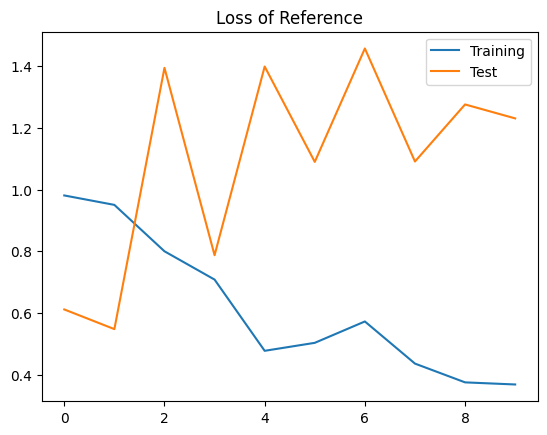

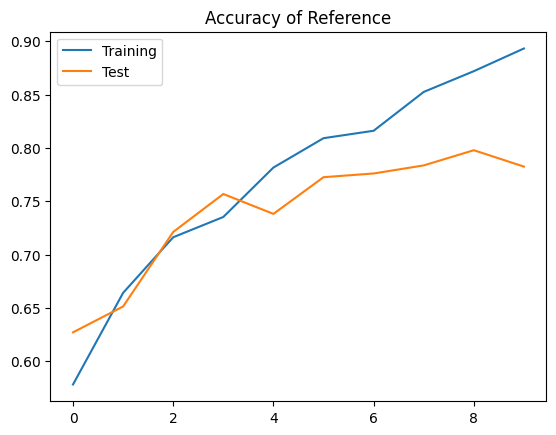

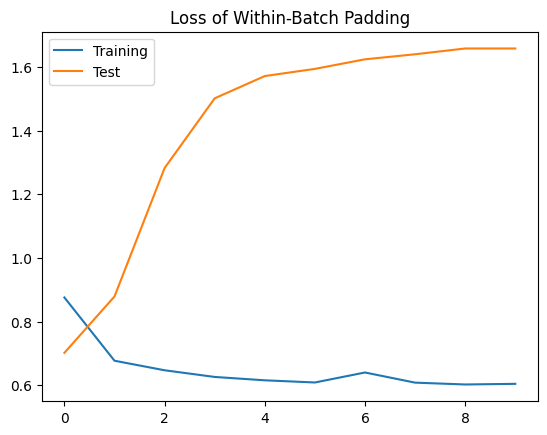

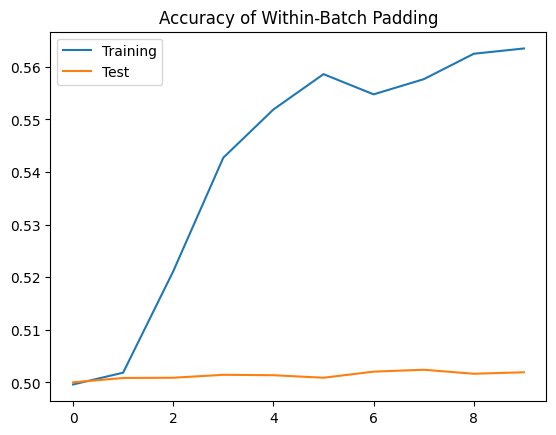

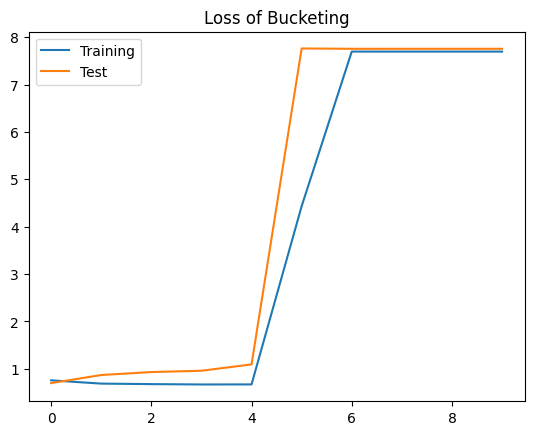

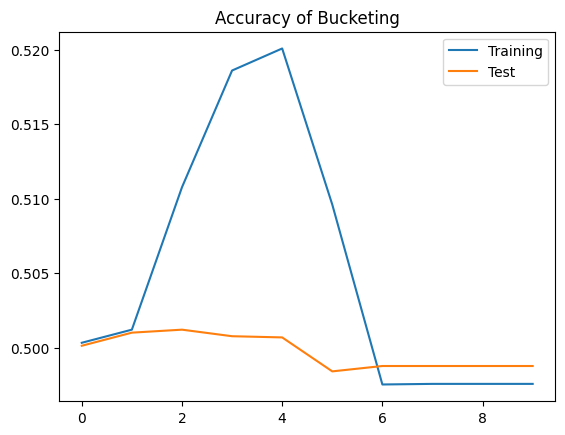

In [74]:
for key, (train_losses, train_accs, test_losses, test_accs) in training_results.items():
  plt.plot(train_losses, label="Training")
  plt.plot(test_losses, label="Test")
  plt.title(f"Loss of {key}")
  plt.legend()
  plt.show()

  plt.plot(train_accs, label="Training")
  plt.plot(test_accs, label="Test")
  plt.title(f"Accuracy of {key}")
  plt.legend()
  plt.show()

- padding & bucketing weren't working really well
  - probably did somethign wrong
- at it was very slow
- with keras layers super simple
  - not so much fiddling around
- but: Reference model is the fastest and quite good

## Writing padding and bucketing ourselves

In [ ]:
train_dataset_size = len(train_sequences)
test_dataset_size = len(test_sequences)

max_sequence_length = int(tf.reduce_max([len(train_sequence) for train_sequence in train_sequences]))

In [ ]:
def truncate_sequences(sequences, length):
  return [sequence[:length] for sequence in sequences]

### Within-Batch Padding

In [ ]:
def model_within_batch_padding():
  sequence_truncation_length = 200

  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=True)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=True)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  # Create Model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)


  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(epochs):
      loss_metric.reset_state()
      accuracy_metric.reset_state()

      for i in range(0, train_dataset_size // batch_size):
        train_sequences_batch = train_sequences[i * batch_size : min((i+1)*batch_size, train_dataset_size)]
        train_sequences_batch_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_batch, maxlen=sequence_truncation_length, padding="pre")
        train_labels_batch = train_labels[i * batch_size : min((i+1)*batch_size, train_dataset_size)]

        batch_loss = train_step(tf.constant(train_sequences_batch_padded), tf.constant(train_labels_batch))

      train_losses.append(loss_metric.result())
      train_accs.append( accuracy_metric.result())

      for i in range(0, test_dataset_size // batch_size):
        test_sequences_batch = test_sequences[i * batch_size : min((i+1)*batch_size, test_dataset_size)]
        test_sequences_batch_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_batch, maxlen=sequence_truncation_length, padding="pre")
        test_labels_batch = test_labels[i * batch_size : min((i+1)*batch_size, test_dataset_size)]

        logits = rnn_loop(tf.constant(test_sequences_batch_padded))
        accuracy_metric(test_labels_batch, logits)
        loss_metric(test_labels_batch, logits)

      test_losses.append(loss_metric.result())
      test_accs.append(accuracy_metric.result())


      if print_training_info:
        print_training_info(epoch+1, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


### Bucketing

In [ ]:
def model_bucketing():
  sequence_truncation_length = 500
  bucket_amt = 10


  # sequences: batch_size, time_steps, values
  @tf.function(jit_compile=False)
  def rnn_loop(sequence_batch):
    old_state = tf.zeros((tf.shape(sequence_batch)[0], hidden_size))  # initial state

    for step in tf.range(tf.shape(sequence_batch)[1]):
        x_t = sequence_batch[:, step]
        x_t = tf.one_hot(x_t, depth=num_words)

        concatenated = tf.concat((x_t, old_state), axis=-1)

        new_state = to_hidden(concatenated)

        old_state = new_state

    o_t = to_output(new_state)

    return o_t

  @tf.function(jit_compile=False)
  def train_step(sequence_batch, label_batch):
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequence_batch)
        loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))

    accuracy_metric(label_batch, logits)
    loss_metric(label_batch, logits)

    return loss

  def bucket_dataset(dataset, bucket_amount, max_length): #max_length is the length of the longest occuring sequence in the dataset
    if (len(dataset[0]) != len(dataset[1])):
      raise ValueError

    bucket_width = max_length // bucket_amount
    bucketed_sequences = [[] for _ in range(bucket_amount)]
    bucketed_labels = [[] for _ in range(bucket_amount)]
    for i in range(len(dataset[0])):
      train_sequence = dataset[0][i]
      train_label = dataset[1][i]
      bucket_indx = (len(train_sequence)-1) // bucket_width
      bucketed_sequences[bucket_indx].append(train_sequence)
      bucketed_labels[bucket_indx].append(train_label)

    return bucketed_sequences, bucketed_labels


  truncated_train_sequences = truncate_sequences(train_sequences, sequence_truncation_length)
  bucketed_train_sequences, bucketed_train_labels = bucket_dataset((truncated_train_sequences, train_labels), bucket_amt, sequence_truncation_length)

  truncated_test_sequences = truncate_sequences(test_sequences, sequence_truncation_length)
  bucketed_test_sequences, bucketed_test_labels = bucket_dataset((truncated_test_sequences, train_labels), bucket_amt, sequence_truncation_length)

  # create model
  to_hidden = tfkl.Dense(hidden_size, activation=tf.nn.tanh)
  to_output = tfkl.Dense(2 if use_softmax else 1)
  to_hidden.build((None, num_words + hidden_size))
  to_output.build((None, hidden_size))
  # if we don't build the layers here, they have no weights :(
  weights = to_hidden.trainable_variables + to_output.trainable_variables

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.losses.BinaryCrossentropy(from_logits=False)
  # gradient clipping!
  optimizer = tf.keras.optimizers.Adam(learning_rate, global_clipnorm=1.)

  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy() if use_softmax else tf.keras.metrics.BinaryAccuracy(threshold=0.)
  loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False) if use_softmax else tf.keras.metrics.BinaryCrossentropy(from_logits=False)

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(1, epochs+1):
      loss_metric.reset_state()
      accuracy_metric.reset_state()

      for train_sequences_bucket, train_labels_bucket in zip(bucketed_train_sequences, bucketed_train_labels):
        bucket_size = len(train_sequences_bucket)

        for i in range(0, max(bucket_size // batch_size, 1)):
          train_sequences_batch = train_sequences_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          max_sequence_length_in_batch = int(tf.reduce_max([len(seq) for seq in train_sequences_batch]))

          train_sequences_padded_batch = tf.keras.preprocessing.sequence.pad_sequences(train_sequences_batch, maxlen=max_sequence_length_in_batch, padding="pre")
          train_labels_batch = train_labels_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          train_sequences_padded_batch_tensor = tf.constant(train_sequences_padded_batch)

          batch_loss = train_step(train_sequences_padded_batch_tensor, tf.constant(train_labels_batch))


      train_losses.append(loss_metric.result())
      train_accs.append(accuracy_metric.result())

      for test_sequences_bucket, test_labels_bucket in zip(bucketed_test_sequences, bucketed_test_labels):
        bucket_size = len(test_sequences_bucket)

        for i in range(0, max(bucket_size // batch_size, 1)):
          test_sequences_batch = test_sequences_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          max_sequence_length_in_batch = int(tf.reduce_max([len(seq) for seq in test_sequences_batch]))

          test_sequences_padded_batch = tf.keras.preprocessing.sequence.pad_sequences(test_sequences_batch, maxlen=max_sequence_length_in_batch, padding="pre")
          test_labels_batch = test_labels_bucket[min(i * batch_size, bucket_size) : min((i+1)*batch_size, bucket_size)]

          test_labels_batch_tensor = tf.constant(test_labels_batch)

          logits = rnn_loop(tf.constant(test_sequences_padded_batch))
          accuracy_metric(test_labels_batch_tensor, logits)
          loss_metric(test_labels_batch_tensor, logits)

      test_losses.append(loss_metric.result())
      test_accs.append(accuracy_metric.result())


      if print_training_info:
        print_training_info(epoch, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1])

  return (train_losses, train_accs, test_losses, test_accs)


### Analysis

In [ ]:
training_results["Within-Batch Padding"] =  model_within_batch_padding()

Epoch: 1
	Training loss: 0.9168446660041809
	Training accuracy: 0.5618589520454407
	Test loss: 0.9344310164451599
	Test accuracy: 0.5876402258872986
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.8373252153396606
	Training accuracy: 0.6839342713356018
	Test loss: 0.7761232256889343
	Test accuracy: 0.607732355594635
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.7543580532073975
	Training accuracy: 0.7103766202926636
	Test loss: 0.7023177146911621
	Test accuracy: 0.6315905451774597
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.5973265767097473
	Training accuracy: 0.7685897350311279
	Test loss: 0.6226027011871338
	Test accuracy: 0.7444911599159241
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.5858439207077026
	Training accuracy: 0.7997596263885498
	Test loss: 0.7396478056907654
	Test accuracy: 0.7226762771606445
--------

In [ ]:
training_results["Bucketing"] = model_bucketing()

Epoch: 1
	Training loss: 1.0202423334121704
	Training accuracy: 0.5450032353401184
	Test loss: 1.057705283164978
	Test accuracy: 0.5223944783210754
-------------------------------------------------------------
Epoch: 2
	Training loss: 0.8235738277435303
	Training accuracy: 0.6504719853401184
	Test loss: 1.8077781200408936
	Test accuracy: 0.574198305606842
-------------------------------------------------------------
Epoch: 3
	Training loss: 0.8912684321403503
	Training accuracy: 0.6880289912223816
	Test loss: 1.42709481716156
	Test accuracy: 0.5936886668205261
-------------------------------------------------------------
Epoch: 4
	Training loss: 0.7731756567955017
	Training accuracy: 0.750732421875
	Test loss: 1.792391300201416
	Test accuracy: 0.625286340713501
-------------------------------------------------------------
Epoch: 5
	Training loss: 0.8880788683891296
	Training accuracy: 0.7908935546875
	Test loss: 2.191258192062378
	Test accuracy: 0.6443063020706177
---------------------

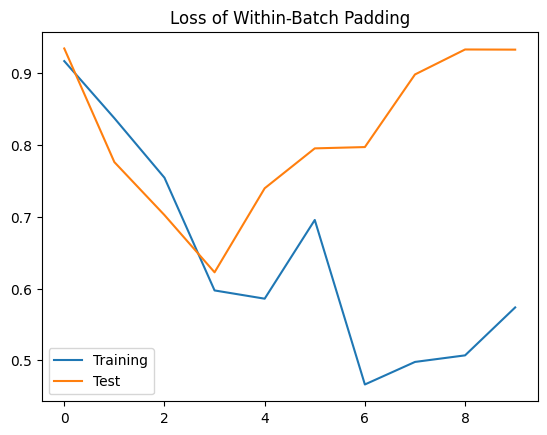

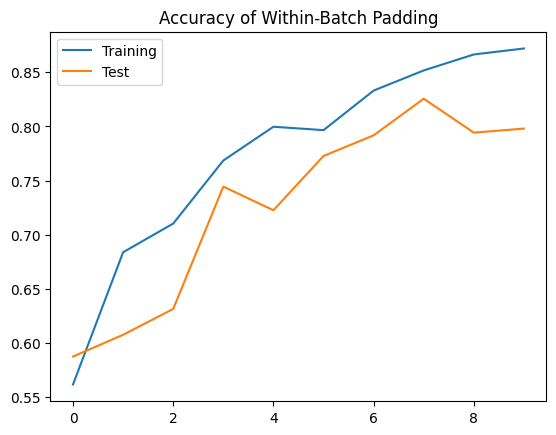

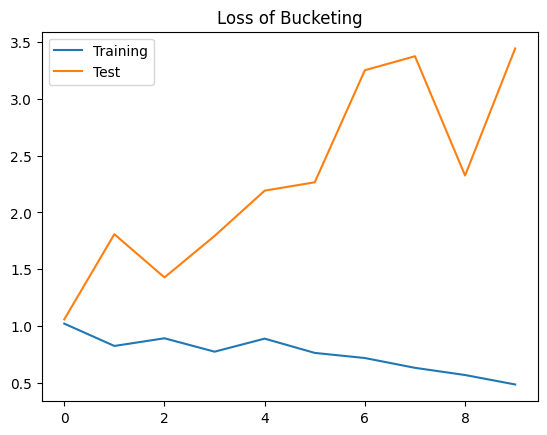

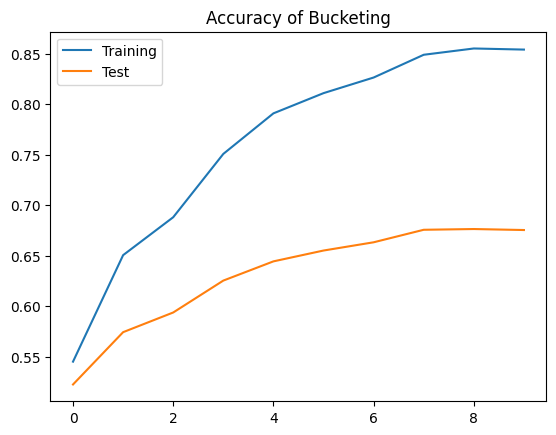

In [68]:
for key, (train_losses, train_accs, test_losses, test_accs) in training_results.items():
  plt.plot(train_losses, label="Training")
  plt.plot(test_losses, label="Test")
  plt.title(f"Loss of {key}")
  plt.legend()
  plt.show()

  plt.plot(train_accs, label="Training")
  plt.plot(test_accs, label="Test")
  plt.title(f"Accuracy of {key}")
  plt.legend()
  plt.show()